# Navigation using Reinforcement Learning

---

This project creates an agent to navigate (and collect bananas!) in a large, square world.

### 1. Start the Environment

**Unity Machine Learning Agents (ML-Agents)** is an open-source Unity plugin that enables games and simulations to serve as environments for training intelligent agents. It has myriads of environments up for a challenge, and in which the environment we will be solving during this project is **Reacher**.
![image.png](https://video.udacity-data.com/topher/2018/June/5b1ea778_reacher/reacher.gif)

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

Let's start by installing all the required dependencies:

In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is provided and can be accessed as below once installed

In [2]:
#export
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents, representing the agent. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
#export
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

The environment is considered <b>solved</b>, when the average (over 100 episodes) of those average scores is at least +30.

### 2. DDPG Agent Solver

The environment is continuous environment which has state space and action space that are both continuous. As such, we would need an agent that can deal with continuous setting. Here **DDPG** algorithm comes to the rescue. Unlike our **DQN** algorithm that is a Q-learning variant which uses deep neural network to approximate the Q-function, **DDPG** also learns policy at the same time as learning Q-function. Therefore, it is a mix between Q-learning and Policy Gradient methods.

![image.png](https://spinningup.openai.com/en/latest/_images/math/5811066e89799e65be299ec407846103fcf1f746.svg)

The reason for choosing **DDPG** is because it is, in a nutshell, **DQN** for continuous action spaces. If you recall, **DQN** deals with environments with discrete action spaces like pressing buttons while **DDPG** can tell how hard to press that button. As same as **DQN**, it uses: 

- Replay Buffers
- Target Networks

The main addition is using calculating the max over actions in the target:
![equationDDPG.png](https://spinningup.openai.com/en/latest/_images/math/4421120861d55302d76c7e2fd7cc5b2da7aea320.svg)
Computing the maximum over actions in the target is a challenge in continuous action spaces. DDPG deals with this by using a target policy network to compute an action which approximately maximizes the Q network.

While I won't go deep down to the details DDPG algorithm, I'll guide you to great resources that does a much better job at explaining it than I would here :)

- [The original paper introducing the DDPG](https://arxiv.org/abs/1509.02971)
- [DDPG implementation by Spinning Up, OpenAI](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)


### 3. Implementation Details

The **DDPG** agent that we will use to solve the environment will be a modified **DDPG** algorithm.

#### Hyperparaments
Note that the hyper parameters used for the training was:
    - n_episodes = 500
        Train for total of 500 episodes until the environment is solved
    - max_t = 1000 
        Maximum of 1000 timesteps per episode
    - start_steps = 10
        Randomly sample actions for 10 episodes to encourage exploration at the start of the learning process
    - learn_frequency = 20
        Learn per 20 timesteps when training.
    - learn_count = 10
        Learn 10 times at the learning step
        
#### Neural network inside the agent

The **Actor** neural network inside the agent is simple shallow network with 3 linear layers with a batch norm within them.

    State value -> 
    LinearLayer(state size, 400) -> Relu ->
    BatchNorm1d(400) -> 
    LinearLayer(400, 300) -> Relu ->
    BatchNorm1d(400) -> 
    LinearLayer(300, action size) ->
    Action values

The **Critic** neural network inside the agent is simple shallow network with 3 linear layers with a batch norm within them.
    
    State value -> 
    Linear(state_size, 400) -> Relu ->
    BatchNorm1d(400) -> 
    Linear(400+action_size, 300) -> Relu ->
    Linear(300, 1) -> 
    Q-value

### 4. Implementation

Import necessary packages:

In [4]:
#export
import torch
from collections import deque
from ddpg_agent import Agent

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Define environment variables:

In [6]:
#export
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

**DDPG** learning algorithm:

In [7]:
#export
def ddpg(n_episodes=500, max_t=1000, start_steps = 10, learn_frequency = 20, learn_count = 10, random_seed = 1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        start_steps (int)     : number of starting steps actions are chosen randomly 
        learn_frequency (int) : frequency of learning per timestep
        learn_count (int)     : number of learning steps to do at learning timestep
        random_seed (int)     : random seed for agent's weights 
    """
        
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed)   #Initialize the Agent
    
    avg_scores_episode = []                    # list containing scores from each episode
    avg_scores_moving = []                     # list containing avg scores from window at each episode
    scores_window = deque(maxlen=100)          # last 100 scores                    
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()                                           # reset noise of the agent

        for t in range(max_t):
            #Randomly sample actions during the starting steps
            if i_episode <= start_steps:
                actions = np.random.randn(num_agents, action_size) # select an action randomly
                actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            else:
                actions = agent.act(states, add_noise=True)     # select an action according to policy (for each agent)
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            dones = env_info.local_done                         # see if episode has finished (for each agent)
            
            # for each agent's experience, save it and learn
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                if t % learn_frequency == 0: # Learn with frequency
                    agent.step(state, action, reward, next_state, done, learn = True, learn_count = learn_count)
                else:
                    agent.step(state, action, reward, next_state, done, learn = False) #just add, don't learn
                    
            states = next_states
            
            scores += rewards                                   # add the rewards from the timestep to the scores
            if np.any(dones):                                   # finish episode if any agent has reached a terminal state
                break

                
        scores_window.append(np.mean(scores))            # save the most recent score to scores window
        
        avg_scores_episode.append(np.mean(scores))       # save the most recent score to avg_scores
        avg_scores_moving.append(np.mean(scores_window)) # save the most recent score window average to moving averages

        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 1 == 0: # Print every episode
            print('\rEpisode {}\tAverage Score: {:.2f} \t Current Score: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(scores)))
            
        #environment is solved
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")        #Save actors' weights
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")      #Save critics' weights
            break
            
    return avg_scores_episode, avg_scores_moving # Return average score of each episode and moving average at that time

Train the agent until it solves the environment.

In [8]:
from workspace_utils import active_session # Udacity workspace utility functions

# run the training loop
with active_session():
    scores, avgs = ddpg(n_episodes=500, max_t=1000, start_steps = 20, learn_frequency = 20, learn_count = 10, random_seed = 1)

Episode 1	Average Score: 0.04 	 Current Score: 0.04
Episode 2	Average Score: 0.05 	 Current Score: 0.05
Episode 3	Average Score: 0.07 	 Current Score: 0.11
Episode 4	Average Score: 0.08 	 Current Score: 0.13
Episode 5	Average Score: 0.10 	 Current Score: 0.15
Episode 6	Average Score: 0.11 	 Current Score: 0.18
Episode 7	Average Score: 0.11 	 Current Score: 0.12
Episode 8	Average Score: 0.13 	 Current Score: 0.24
Episode 9	Average Score: 0.15 	 Current Score: 0.29
Episode 10	Average Score: 0.14 	 Current Score: 0.09
Episode 11	Average Score: 0.14 	 Current Score: 0.10
Episode 12	Average Score: 0.13 	 Current Score: 0.10
Episode 13	Average Score: 0.13 	 Current Score: 0.14
Episode 14	Average Score: 0.14 	 Current Score: 0.16
Episode 15	Average Score: 0.13 	 Current Score: 0.05
Episode 16	Average Score: 0.13 	 Current Score: 0.12
Episode 17	Average Score: 0.13 	 Current Score: 0.15
Episode 18	Average Score: 0.13 	 Current Score: 0.11
Episode 19	Average Score: 0.13 	 Current Score: 0.05
Ep

Plot the scores returned during training.

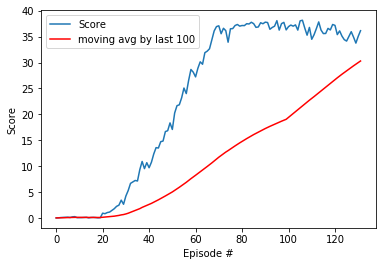

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg by last 100')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

Close the environment once done.

In [ ]:
env.close()

### 5. Command-Line usage parser
The following is parser for the command line interface for the DDPG solving the unity environment. 
<b>Not to be executed</b>

In [ ]:
#export
if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_episodes', type=int, default=500)
    parser.add_argument('--max_t', type=int, default=1000)
    parser.add_argument('--start_steps', type=int, default=20)
    parser.add_argument('--learn_frequency', type=int, default=20)
    parser.add_argument('--learn_count', type=int, default=10)
    parser.add_argument('--random_seed', type=int, default=1)
    args = parser.parse_args()
    
    ddpg(n_episodes = args.n_episodes, max_t = args.max_t, start_steps = args.start_steps, \
         learn_frequency = args.learn_frequency, learn_count = args.learn_count, random_seed = args.random_seed)
env.close() 


### 6. Generate script from the notebook
Throughout this notebook you've been seeing cells marked with ```#export```. The script below picks cells that are marked and append them into python script. This is adopted from fast-ai's deep learning course practice.

In [4]:
!python notebook2script.py Report.ipynb

Converted Report.ipynb to nb_Report.py


After running the cell above, `nb_Report.py` script should have been generated in your workspace. 

### 7. Run the script from the command-line

In [ ]:
!python nb_Report.py

### 8. Conclusions and Future Work

#### Summary

We've just learned to control double joints in Unity Environment, yay! Our DDPG agent proved to be versalite and able to solve the environment during repeated trials. This, by itself, proves that DDPG agent is able to solve such continuous control scenarios.

Moreover, we manipulated 20 agents at the same time and solved the environment. I'm sure you can see how strong DDPG algorithm is. Its ability to deal with completely continuous setting makes it valuable in real-world scenario the **robotics**. In real-world, everything is continuous, therefore DDPG is something to try on.

And, as always, you are most welcome to play around with the hyperparameters to make it even more efficient.

### Future work

This was DDPG agent with slight hyperparameters and training modifications. There are two ways we can go from here. First of all, we could try to solve even harder environment or even better, try the algorithm with robots! While I don't have any robots that I could use, I will direct you to harder Unity enviroment, [the Crawler](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#crawler). You are encouraged to follow their setup guide and tryout the agent we used here.

Secondly, while DDPG can achieve great performance sometimes, it is frequently brittle with respect to hyperparameters and other kinds of tuning. A common failure mode for DDPG is that the learned Q-function begins to dramatically overestimate Q-values, which then leads to the policy breaking, because it exploits the errors in the Q-function. There have been numerous improvements since 2015 when DDPG was first introduced. I encourage you to check out [(TD3)Twin Delayed DDPG](https://arxiv.org/abs/1802.09477) and [(D4PG) Distributed Distributional Deterministic Policy Gradients](https://arxiv.org/abs/1804.08617).
